# Tutorial for hdf5 

In this tutorial we provide a guide on how to load and evaluate the forecasts for California belonging to the next day CSEP grid-based forecast database. This is a database containing daily forecasts produced by 27 different models covering the period from 01 August 2007 to 30 August 2018. Not all models cover the whole period except for the ETAS model. For each day, a forecast is represented by a space-magnitude grid reporting the expected number of events in each cell. All the forecasts are based on the same space-magnitude grid which is the combination of a grid on the spatial domain and a grid on the magnitude domain. The spatial grid is composed by $0.1^\circ \times 0.1^\circ$ (lat x lon) spatial cells, and one bin for the depth going from $0$ to $30$km. The magnitude grid is composed by $0.1$ $M_w$ magnitude units cells.  Essentially, for each day, a forecast is just a table reporting the bin extremes (e.g. minimum longitude, maximum longitude, etc..) and the expected number of events in the respective space-magnitude bin. see Section [1](#section1)

The forecasts are provided as `.hdf5` files representing a system of nested folders. The system is based on a hierarchy composed by year, month, day, so that, in the `.hdf5` file we have one folder per year, inside each year folder we have one folder per month, and inside each month folder we have one file per day representing the forecast for that day. The forecast folder's hierarchy should look like this one:

ETAS/  
├── 2007/  
│   ├── 01/  
│   │   ├── forecast_01_01_2007.dat  
│   │   ├── forecast_01_02_2007.dat  
│   │   ├── ...  
│   │
│   ├── 12/  
│   │   ├── forecast_12_01_2007.dat  
│   │   ├── forecast_12_02_2007.dat  
│   │   ├── ...  
├── 2008/  
│   ├── 01/  
│   │   ├── forecast_01_01_2008.dat  
│   │   ├── forecast_01_02_2008.dat  
│   │   ├── ...  
│   ├── ...  
├── ...  
├── 2018/  
│   ├── 01/  
│   │   ├── forecast_01_01_2018.dat  
│   │   ├── forecast_01_02_2018.dat  
│   │   ├── ...  


The .hdf5 files can be downloaded here. We will use the ETAS and STEP forecast to show: how to download a forecast, how to load the forecast, how to create a cumulative forecast, and how to run daily CSEP consistency and comparative tests. The tutorial is structured as follow: we start by showing how to load a forecast in `.hdf5` format, how to create cumulative forecasts for longer time periods, and how to download the observations from the ComCat catalogue. Then, we show how to visualise the spatial, temporal, and magnitude distributions provided by a model, and compare them with observations. After, we show how to perform CSEP consistency and comparisons tests, providing guidance on how to interpret the results. We conclude showing how to create an `.hdf5` file for user-made forecasts so the code can be reused to evaluate new models.

## pyCSEP installation

The fist step is to install `pyCSEP` and load the python libraries we are going to use. The [`pyCSEP` installation page](https://docs.cseptesting.org/getting_started/installing.html) provides guidance on how to install the `pyCSEP` toolkit. Other libraries we need are `pandas`, `numpy`, `cartopy`, `datetime`, and `matplotlib`. 

In [1]:
import pandas as pd
import numpy as np
import cartopy
from datetime import datetime 
import matplotlib.pyplot as plt

import csep
from csep.utils import datasets, time_utils, plots

import warnings
warnings.filterwarnings("ignore") # ignore warnings - set to warnings.filterwarnings("default") for default warnings setting 

## Downloading a forecast 
We provide two ways to download a forecast: through Zenodo or through the CSEP website. On Zenodo, all the forecast, the code, and this tutorial are in a single zip folder, openly accessible at REF. The forecast can also be downloaded one by one from the CSEP website at the following [link](https://cseptesting.org/grid-based-forecasts/). There, at the bottom at the page, there is a Downlaod section with the links to download the code used in this tutorial, this tutorial, and a table listing all the available models as shown in the figure below. The last columns contains two links, one to download the `.hdf5` for the model, and the second providing a description of the model. The table also report some summary information about the forecasts as starting and end date, cutoff magnitude and number of missing days. In this tutorial, we will use the ETAS and STEP models, therefore the first step is to download the two `.hdf5` files. 

![alt text](download.png)

### Sanity checks
Once the dowload is done, you should have two new files called `ETAS_1day.hdf5` and `STEP_1day.hdf5`. The next step is to check is the download went well. To this end, we need to calculate the checksum for the file. This can be done by

- open a terminal and navigate to the folder where the files are stored
- run the following command `md5sum file_name.hdf5`

The output should be the following 

`md5sum ETAS_1day.hdf5`
<br>
`2821d0735169f0aa2932959176f128dc  ETAS_1day.hdf5`
<br>
<br>
`md5sum STEP_1day.hdf5`
<br>
`089f38770dd97a336de4ad7f346c695c  STEP_1day.hdf5`

## Loading the forecast
The `.hdf5` file contains all the forecasts produced by a model, so the first step is to load the `.hdf5` file in a more manageable format. To do this, we provide a python file (`.py`) containing all the functions that will be used throughout the tutorial. Here, we show how to load all the forecasts produced by a model, but also, how to load only the forecasts produced in a specified time interval. The code can be downloaded REF or on Zenodo. The file containing the functions is called `functions_for_hdf5.py`. To load the functions contained in the file is sufficient to place the `functions_for_hdf5.py` in the working folder and run the command below

In [2]:
# import functions to be used in tutorial
import functions_for_hdf5 as f_hdf5

To load all the forecasts contained in the  `.hdf5` we can use the function `load_hdf5_to_dict`. This function takes in input the name of the file (it has to be in the working directory) or the file path, and returns a dictionary with the same nested structure as the `.hdf5` file. This will load the forecasts for all the days present in the `.hdf5` file because the flag `all_dates` is set to `True`. We suggest to not run the following code if not interested in the whole forecasting period.   

In [3]:
# Import forecast for all available days. 
###########
# WARNING # This may be memory heavy, we suggest loading custom time ranges.
###########
hdf5_filename = 'ETAS_1day.hdf5' 

flag_cell = False
if flag_cell:
    ETAS_whole = f_hdf5.load_hdf5_to_dict(hdf5_filename, all_dates = True) # load all forecasts in the file

The same function allows also to specify a starting and an end date and to load only the forecasts in between. The starting and end date must be specified in the format `%d/%m/%y` and the flag `all_dates` must be removed or set to `False` (which is the default value). For this example, we are going to use only forecasts relative to the year 2010. This is because this is the year of the El Mayor-Cucapah earthquake, a magnitude 7.2 earthquake occurred the 4th April 2010 on the Laguna Salada fault in Southern California.

In [4]:
#load forecasts for a custom period of time 
etas_filename = 'ETAS_1day.hdf5' 
ETAS_2010 = f_hdf5.load_hdf5_to_dict(etas_filename, # file path
                                     start_date = '01/01/2010', # starting date 
                                     end_date = '31/12/2010') # end date

Loading year: 2010
Loading month: 1
Loading month: 10
Loading month: 11
Loading month: 12
Loading month: 2
Loading month: 3
Loading month: 4
Loading month: 5
Loading month: 6
Loading month: 7
Loading month: 8
Loading month: 9


The function `load_hdf5_to_dict` returns a dictionary. The dictionary is structured following the same nested structured explained earlier. We have one key per year, the value corresponding to a year is itself a dictonary with keys representing the months of the year for which we have forecasts. The keys of the month dictionary are the names of the files representing each daily forecast. Each forecast is a `pandas.DataFrame` with nine columns. Each row represents a space-magnitude bin, while the columns represent, respectively, minimum and maximum longitude, minimum and maximum latitude, minimum and maximum depth, minimum and maximum magnitude, expected number of events in the bin, and an identifier. A typical forecast for a day should look like the one below. 

In [5]:
# check first row of the forecast relative to 1st April 2010
ETAS_2010['2010']['4']['ETAS_4_1_2010-fromXML_dat'].head()

,0,1,2,3,4,5,6,7,8,9
0,-125.400002,-125.300003,40.099998,40.200001,0.0,30.0,3.95,4.05,0.000026,1.0
1,-125.400002,-125.300003,40.099998,40.200001,0.0,30.0,4.05,4.15,0.000021,1.0
2,-125.400002,-125.300003,40.099998,40.200001,0.0,30.0,4.15,4.25,0.000017,1.0
3,-125.400002,-125.300003,40.099998,40.200001,0.0,30.0,4.25,4.35,0.000013,1.0
4,-125.400002,-125.300003,40.099998,40.200001,0.0,30.0,4.35,4.45,0.000011,1.0


In [6]:
# check the number of rows and columns
ETAS_2010['2010']['1']['ETAS_1_1_2010-fromXML_dat'].shape

(391782, 10)

In [7]:
# import STEP forecasts
step_filename = 'STEP_1day.hdf5' 
STEP_2010 = f_hdf5.load_hdf5_to_dict(step_filename,
                                     start_date = '01/01/2010', 
                                     end_date = '31/12/2010')

Loading year: 2010
Loading month: 1
Loading month: 10
Loading month: 11
Loading month: 12
Loading month: 2
Loading month: 3
Loading month: 4
Loading month: 5
Loading month: 6
Loading month: 7
Loading month: 8
Loading month: 9


## Loading the earthquake catalogue
We use the functions provided by the `PyCSEP` library to retrieve the earthquake catalogue with which we will be evaluating the forecasts. The `PyCSEP` provides automated functions to access the [ComCat catalogue](https://docs.cseptesting.org/tutorials/catalog_filtering.html) and, therefore, this is the one we use in this tutorial. A more detailed guide to access different catalogues using `PyCSEP` or to load your one one can be found [here](https://docs.cseptesting.org/tutorials/catalog_filtering.html) and [here](https://docs.cseptesting.org/concepts/catalogs.html).

To access the ComCat catalogue, we need to define a starting and end date, a cutoff magnitude and spatial region. Only events within the starting and end date, with magnitude above the cutoff value and within the spatial region will be used for the evaluation. This is done in two steps:

- loading all the events in the catalogue between start and end date
- filter for magnitude and spatial region

The code below queries the ComCat catalogue and prints summary information on the downloaded data. The output is a `csep.core.catalogs.CSEPCatalog` object, a special class provided by `pyCSEP`. This class provides many tools to explore the earthquake catalogue ranging from plotting to obtain the earthquake counts per space-magnitude bin. The full list of tools for this class can be found [here](https://docs.cseptesting.org/reference/generated/csep.core.catalogs.CSEPCatalog.html#csep.core.catalogs.CSEPCatalog).

In [8]:
# set start and end date
start_time = csep.utils.time_utils.strptime_to_utc_datetime('2010-01-01 00:00:00.0')
end_time = csep.utils.time_utils.strptime_to_utc_datetime('2010-12-31 23:59:59.0')
# retrieve events in ComCat catalogue between start and end date
catalog = csep.query_comcat(start_time, end_time)

Fetched ComCat catalog in 7.172467947006226 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 2010-01-01 02:33:42.820000+00:00
End Date: 2010-12-31 17:59:32.590000+00:00
Min Latitude: 31.5136667 and Max Latitude: 42.4743333
Min Longitude: -125.399 and Max Longitude: -113.1186667
Min Magnitude: 2.5
Found 4998 events in the ComCat catalog.


We recall that the forecasts are for earthquakes with magnitude $M \geq 3.95$ occurred in the CSEP spatial region. Therefore, we need to filter the events with magnitude below 3.95 and outside the region. The space-magnitude region is defined by specifying a one dimensional grid on the magnitude domain, a two dimensional grid on the spatial domain, and by combining them. The magnitude grid is created with the `csep.regions.magnitude_bins()` functions taking as input the minimum and maximum magniude, and the bin width. For the space region, all the forecasts are defined on the same region which is the one used in the RELM experiment. The `PyCSEP` library provides easy access to this region using the `csep.regions.california_relm_region()` function.

In [9]:
min_mw = 3.95 # minimum magnitude
max_mw = 8.95 # max magnitude after which is just one bin
dmw = 0.1 # bin width

# Create space and magnitude regions. The forecast is already filtered in space and magnitude
magnitudes = csep.regions.magnitude_bins(min_mw, max_mw, dmw)
region = csep.regions.california_relm_region()

# Bind region information to the forecast 
space_magnitude_region = csep.regions.create_space_magnitude_region(region, magnitudes)

Once we have created the space-magnitude region we can use it to filter the observed catalog. The filtering is done in two steps, first we filter out the earthquakes with magnitude below or equal 3.95, then we filter using the space-magnitude region created before. In the last step, the `pyCSEP` library essentially counts the number of earthquakes in each space-magnitude bin so that the information provided by the forecast and the data is coherent. Printing a catalogue in `pyCSEP` format shows some summary information similar to the one provided when downloading the catalogue. For the 2010 example, 187 earthquakes above magnitude $3.95$ (and maximum magnitude 7.2) occurred in California.

In [10]:
# filter magnitude below 3.95
catalog.filter('magnitude >= 3.95')
# filter events outside spatial region
catalog.filter_spatial(space_magnitude_region)
# print summary information
print(catalog)


        Name: None

        Start Date: 2010-01-04 14:24:54.440000+00:00
        End Date: 2010-12-23 12:37:35.020000+00:00

        Latitude: (31.715, 40.9511667)
        Longitude: (-125.2775, -114.8613333)

        Min Mw: 3.95
        Max Mw: 7.2

        Event Count: 187
        


To visualise a catalogue, we can simply apply the function `plot()` to the catalogue object, as `[catalogue].plot()`. This function allows to specify some arguments as the figure title, the background geographical map, the color of the points and their size. For a complete list of arguments we refer to the following [link](https://docs.cseptesting.org/tutorials/plot_customizations.html) and references therein. The figure shows the El-Major-Cucapah earthquake sequence in Southern California, and a smaller, but still relevant, cluster of events in the north. This catalogue will be used to evaluate the forecasts the reminder of the tutorial. 

<GeoAxes: title={'center': 'ComCat 2010'}>

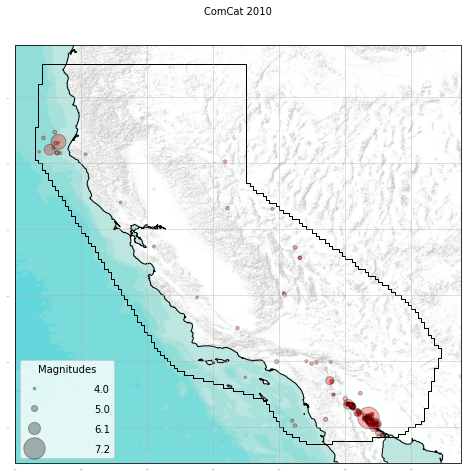

In [11]:
args_catalog = {'title': 'ComCat 2010', # set figure title 
                'basemap': 'ESRI_terrain', # set background map with ESRI_imagery shows a colored map
                'markercolor': 'red', # set color for observations
                'markersize': 1} # set size for observations
# visualise observations
catalog.plot(plot_args=args_catalog)

## Create cumulative forecast
One may be interested in obtaining the cumulative forecast for periods of time like a week, a month, or a year. In this context, a cumulative forecast is a grid-based forecast, as the one described in the previous Section, but with the earthquake rate per bin being the sum of earthquake rates in each day of the time period. The function `get_cumulative_forecast()` takes as input a dictionary of forecasts, as the one described above, and returns a `csep.core.forecasts.GriddedForecast` object. This is the class used in pyCSEP to represent grid-based earthquake forecasts. As for `csep.core.catalogs.CSEPCatalog` objects, pyCSEP provides various tools to analyse a forecast in this format. A more detailed description of a `csep.core.forecasts.GriddedForecast` is provided [here](https://docs.cseptesting.org/concepts/forecasts.html), while a complete list of tools can be found [here](https://docs.cseptesting.org/reference/generated/csep.core.forecasts.GriddedForecast.html#csep.core.forecasts.GriddedForecast).

The code below creates the cumulative forecast with all the forecasts contained in the `.hdf5` file. This is because the argument `all_dates` is set to `True`. Later on we will show how to create cumulative forecasts for custom time periods.

In [12]:
# create the cumulative forecast
cumulative_ETAS = f_hdf5.get_cumulative_forecast(dict_fore = ETAS_2010, # dictonary representing a set of forecasts 
                                                 forecast_name = 'ETAS', # name of the forecast used for plotting
                                                 all_dates = True) # import all the forecasts present in the dictonary
# create the cumulative forecast
cumulative_STEP = f_hdf5.get_cumulative_forecast(dict_fore = STEP_2010, 
                                                 forecast_name = 'STEP', 
                                                 all_dates = True)

## Visual exploration 
Before computing the CSEP consistency and comparison tests, we may be interested in visualising the forecasts provided a model. This involves plotting their spatial, temporal, and magnitude distribution, and comparing them against observed earthquakes. Consequently, this Section is divided in three parts corresponding to the different aspects (spatial, temporal, magnitude) of the forecasts.

### Spatial distribution 
For the spatial distribution, we can use the tools provided by pyCSEP to plot the spatial distribution of `csep.core.forecasts.GriddedForecast` objects, therefore we show the spatial distribution of the cumulative forecast. The code below plots the spatial distribution of the cumulative ETAS and STEP forecast for 2010. Similarly to how catalogues are plotted, we can use the `[forecast].plot()` function. To superimpose the observations to the map, we need to pass the forecast plot as `ax` argument when we plot the catalogue. In this way, the observations will be plotted on top of the map reporting the earthquakes rate per spatial bin expected by the model.  

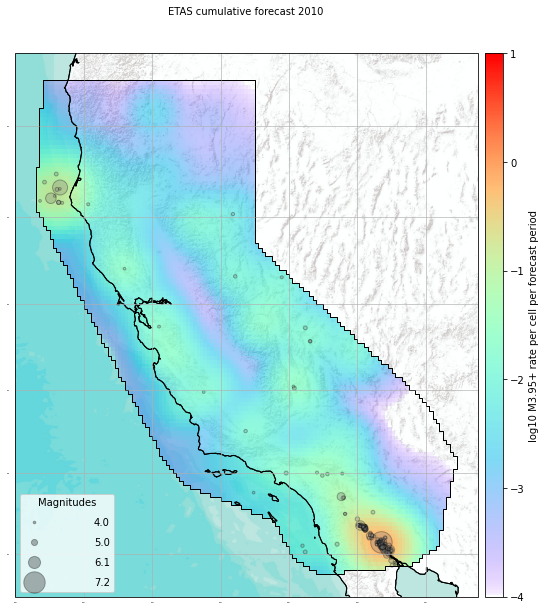

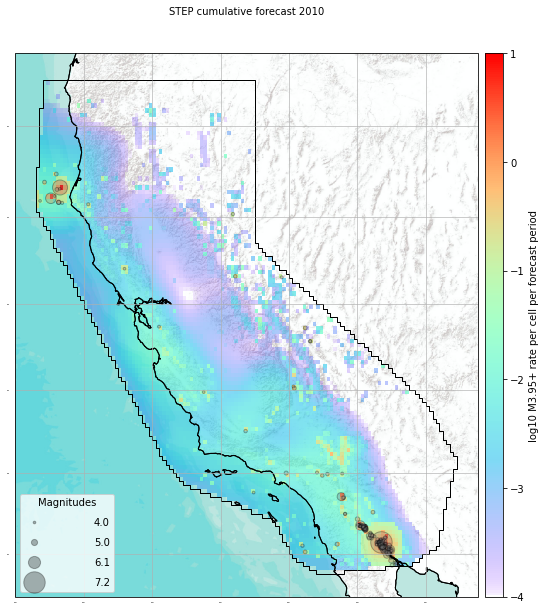

In [13]:
args_forecast = {'grid_labels': True,
                 'basemap': 'ESRI_imagery', # set background image if non a black and white (ESRI_terrain) version of the costline is used
                 'cmap': 'rainbow', # color palette for the logarithm of number of events 
                 'alpha_exp': 0.5, # level of trasparency
                 'projection': cartopy.crs.Mercator(), # projection
                 'clim':[-4, 1]} # limits of the color palette

args_catalog['title'] = 'ETAS cumulative forecast 2010' # title of the plot
args_catalog['markercolor'] = 'grey' # color of the observations

# get ETAS plot
ax_1 = cumulative_ETAS.plot(plot_args=args_forecast)
ax_2 = catalog.plot(ax=ax_1, plot_args=args_catalog)

# get STEP plot
args_catalog['title'] = 'STEP cumulative forecast 2010' # title of the plot
ax_1 = cumulative_STEP.plot(plot_args=args_forecast)
ax_2 = catalog.plot(ax=ax_1, plot_args=args_catalog)

Looking at the figures above we can appreciate the differences between the spatial distributions of the ETAS and STEP model. Indeed, despite the two models roughly highlights the same areas (top-left and bottom-right corners) they do that in different ways. More specifically, the ETAS model provides a smoother spatial distribution than the STEP model and does not account for fault information. On the other hand, the STEP model provides a spatial forecast with more abrupt changes and that accounts for fault information. In fact, in the bottom-right corner we can see the highlighted red region following the faults. 

The figures above are not very useful to understand the differences in the range of values over which the number of events varies for the two forecasts. We notice that when setting the `clim` argument in `args_forecast` this has the effect of showing with the same color all the bins with values below or above the limits. In this case, we have set `clim = [-4. 1]` which means that all the bins with values below $-4$ and above $1$ have, respectively, the same color. So, the maps above should not be used to study the range over which the forecasts are varying. If we do not set the argument `clim` this will reflect the actual range of the logarithm of the expected number of events, however, this may be problematic for two reasons: i) if we have bins with zero expected events it will produce infinity when calculating the logarithm, and ii) the visual comparison of the spatial distribution of the number of events becomes harder because each model will be 

We can study the difference in the spatial rate distribution under the two models, extracting the rates for each space-magnitude bin and study their distribution. The number of events per spatial bin can be retrieved using the command `forecast.spatial_counts()` which returns a vector of dimension $7682$ (number of spatial bins). Once we have the vector of the spatial rates for each forecast, an easy way to get summary information for the spatial bin counts is to store them in a `pandas.DataFrame` and run the command `.describe()` on it. 

In [14]:
# Extract number of expected events per spatial bin
ETAS_rates = cumulative_ETAS.spatial_counts()
STEP_rates = cumulative_STEP.spatial_counts()

# store them and calculate summary information
pd.DataFrame({'ETAS': ETAS_rates,
              'STEP': STEP_rates}).describe() 

,ETAS,STEP
count,7682.000000,7682.000000
mean,0.017649,0.019237
std,0.061220,0.502864
min,0.000032,0.000000
25%,0.000943,0.000042
50%,0.004079,0.000784
75%,0.009750,0.003522
max,0.722920,41.710168


The table above quantifies the differences we have seen in the spatial distributions. Indeed, despite the forecasts having a similar average rate, they have very different standard deviations (`std`) with the one for STEP being more than 8 times the `std` of ETAS. This confirms that the ETAS model is smoother than STEP. Also, we can see that they have very different ranges. In fact, the STEP models spatial counts range from $0$ to $41$ while ETAS only between $\sim 10^{-6}$ and $0.72$. We also notice that the $50$ and $75\%$ percentiles of the ETAS spatial counts are higher than the STEP ones. This indicates that, despite having a lower maximum spatial count, the probability that a spatial bin count exceeds a certain threshold is higher for ETAS than for STEP (if the threshold is sufficiently below $0.72$). This is again an effect of ETAS being smoother and therefore having less varying and less extreme spatial counts than STEP. 

To complete the analysis on the difference in the spatial counts, we show in the code below how to plot the histograms of the logarithm of the spatial counts for each forecast. To do that, we need to remove the zero counts from the STEP spatial counts. In this example, we replace the zeros in the spatial counts with $10^{-20}$. We chose $10^{-20}$ because this is below the lowest spatial counts above zero for the STEP model. The plot below confirms what we have seen before: STEP spatial counts varies over a wider range (it is the only model with counts below $10^{-5}$ and above $10^0$); the ETAS model spatial counts have a higher exceedance probability for thresholds below 0. But it also provides additional information on the number of zero count bins which does not contitutues the majority of the bins but are still a non-negligible number. 

This type of analysis is also useful to determine the value of an hypothetical water level for the space-magnitude rates provided by a forecast. A water level is a minimum value that it is assumed for the rates, so that the bins where the rate is zero will instead assume the water level. The value of the water level may alter the results if it is too large, therefore, a safe choice is to set it below the minimum rate provided by a forecast. 

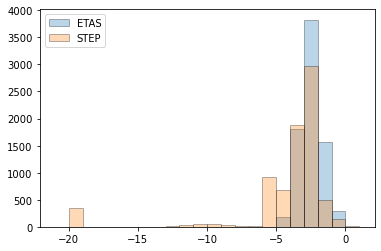

In [15]:
ETAS_logrates = np.log10(ETAS_rates) # calculate log of ETAS spatial counts
STEP_rates = np.where(STEP_rates > 0, STEP_rates,  10**(-20)) # replace 0 with 10^{-20} for STEP spatial counts
STEP_logrates = np.log10(STEP_rates) # calculate log of STEP spatial counts


# plot histograms of the logarithm of the spatial counts.
plt.hist(ETAS_logrates, label='ETAS', alpha = 0.3, edgecolor = 'black', bins = np.arange(-21, 2, 1))
plt.hist(STEP_logrates, label='STEP', alpha = 0.3, edgecolor = 'black', bins = np.arange(-21, 2, 1))

plt.legend()
plt.show()

### Temporal distribution
For the temporal distribution, it is more appropriate to work with the `.hdf5` file than with the daily forecasts produced by a model. We provide three ways to visualise the temporal distribution of earthquakes rates: two ways to visualise the absolute number of earthquakes per day, and one way for the cumulative number. In all cases, the uncertainty around the expected earthquakes rate by a model is calculated assuming a Poisson distribution with parameter equal to the expected rate. 

For the absolute number of events, we look at the logarithm of the number of earthquakes per day, and we plot it against the observed number of earthquakes (along with the uncertainty) or alternatively we plot the daily rate provided by the model, along with the observed magnitudes. Both plots can be produced using the same function from the ones we provide, the `f_hdf5.get_N_plot_multi()` function. This takes as arguments, a list of dictionaries representing forecasts as the ones created before, labels for the models, an observed catalog in `csep.core.catalogs.CSEPCatalog` format, the type of plot, various plot specifications as the size of the points, the resolution of the figure, and similars. To produce the plot with the observations and the uncertainty it is sufficient to set the `show_obs_counts` and `show_uncertainty` arguments to `True`. The dashed lines represents the upper end of the confidence interval of level `alpha_level`. We only show the upper end of the interval, as the lower one is often zero and therefore minus infinity in log-scale.

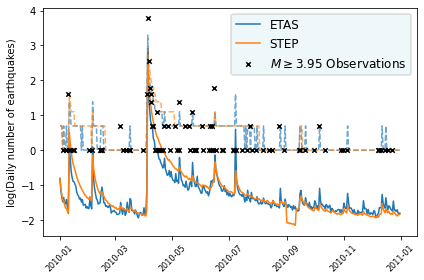

In [16]:
f_hdf5.get_N_plot_multi(dict_fore_array=[ETAS_2010, STEP_2010], # list of dictonaries of forecasts
                        forecast_label = ['ETAS', 'STEP'],  # list of forecasts names
                        catalog=catalog,  # observed catalogue
                        alpha_level =  0.05,  # level of the confidence intervals
                        type = 'rates', # type of plot (if = 'cumulative' produces the cumulative plot) 
                        size_p = 20, # size of the points in the plot
                        return_df = False, # returning a Pandas.data.frame used for plotting 
                        save_plot = True, # saving the plot  
                        fig_dpi = 500, # figure resolution 
                        file_name = 'abs_STEP_ETAS_temp_obs_uncert.png', # file name for the figure
                        show_obs_counts = True, # show observed counts
                        show_uncertainty = True) # show uncertainty

If we are interested in only one model, just provide a list with only one element as `dict_fore_array` argument. Setting the argument `return_df` to `True` also returns a `pandas.DataFrame` containing the data showed in the plot.

If we set `show_obs_counts` and `show_uncertainty` to `False` we obtain the second way of plotting absolute rates, which is along with the observed magnitudes (red dots). 

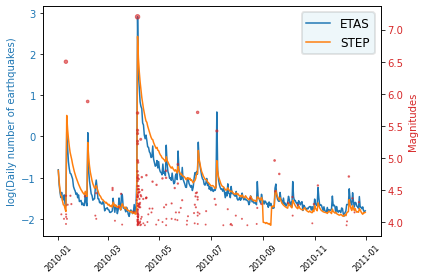

In [17]:
f_hdf5.get_N_plot_multi(dict_fore_array=[ETAS_2010, STEP_2010], # list of dictonaries of forecasts
                        forecast_label = ['ETAS', 'STEP'],  # list of forecasts names
                        catalog=catalog,  # observed catalogue
                        alpha_level =  0.05,  # level of the confidence intervals
                        type = 'rates', # type of plot (if = 'cumulative' produces the cumulative plot) 
                        size_p = 20, # size of the points in the plot
                        return_df = False, # returning a Pandas.data.frame used for plotting 
                        save_plot = True, # saving the plot  
                        fig_dpi = 500, # figure resolution 
                        file_name = 'abs_STEP_ETAS_temp_obs_no_uncert.png', # file name for the figure
                        show_obs_counts = False, # show observed counts
                        show_uncertainty = False) # show uncertainty

The same function is used also to plot the cumulative number of earthquakes per day. The difference is that we need to specify `type = 'cumulative'` and we can omit the `show_obs_counts` and `show_uncertainty` arguments as they are not used for this type of plot. All the other arguments are the same as before.

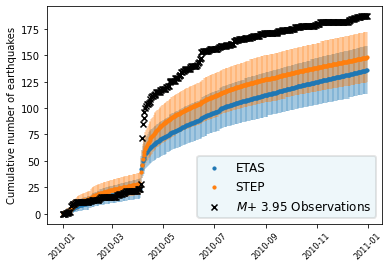

In [18]:
f_hdf5.get_N_plot_multi(dict_fore_array=[ETAS_2010, STEP_2010],
                        forecast_label = ['ETAS', 'STEP'], 
                        catalog=catalog, 
                        alpha_level =  0.05, 
                        type = 'cumulative', 
                        return_df = False, 
                        save_plot = True, 
                        fig_dpi = 500, 
                        file_name = 'cumulative_STEP_ETAS_temp.png')

### Magnitude distribution
For the magnitude distribution, we provide a function to plot the magnitude rates of a cumulative forecasts. We only consider cumulative forecasts, as the number of observations per day is usually low, and therefore the results would be strongly influenced by the presence of rare large magnitude events. The magnitude rates are shown by reporting the logarithm of the number of earthquakes (expected and observed) with magnitude greater or equal $m$ for varying values of $m$. In this context, the values of $m$ are the midpoints of the magnitude bins, and the number of earthquakes with magnitude above $m$ is simply the sum of the expected rates in bins with midpoint greater or equal than $m$. The plot is obtained using the `fhdf5.get_mag_plot()` function. This takes a list of cumulative forecast in `csep.core.forecasts.GriddedForecast` format, an observed catalogue in `csep.core.catalogs.CSEPCatalog` format, and the same arguments as before regarding saving or not the figure, the resolution, and the file name. 

The figure below shows that the models provide different magnitude distributions at magnitudes above 6. The ETAS model has a standard Gutenberg-Richter (GR) law, which is linear, with the last point representing the sum of the values above magnitude $8.95$. The STEP model instead departs from a standard GR-law for magnitudes above 6 and seems to fit the data slightly better. None of the model adeguately represent the tails of the magnitude distribution. However, this is expected because we are considering a particularly active year and therefore, the probabilities of large magnitude events estimated using the observations are larger than what they should be. Considering a longer period of time will likely reduce the differences between expected and observed magnitude rates.

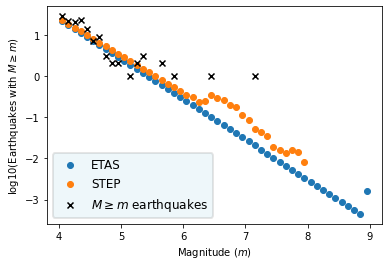

In [19]:
# produce magnitude plot
f_hdf5.get_mag_plot(forecasts_list = [cumulative_ETAS, cumulative_STEP], # list of forecasts
                    catalog = catalog, # observed catalogue
                    save_fig = True, # saving the plot  
                    fig_dpi = 500, # figure resolution 
                    fig_name = 'mag_distro.png') #file name for the figure 

## CSEP consistency tests
In this Section, we show how to compute CSEP consistency tests for cumulative forecats, and on a daily basis for a set of forecasts produced by a model. We remark the fact that these tests assess the consistency between a forecast and the observations, and should not be used to compare two models. Indeed, if model A is consistent and model B is not, it does not imply that model A is superior, it may actually happen that model B assigns higher likelihood to the observations. 

There are multiple CSEP consistency tests, each one isolating and evaluating a specific aspect of the forecat, i.e. the distribution of the total number of earthquakes, the magnitude distribution, the spatial distribution, but also more generic tests assessing the overall consistency across multiple aspects. The functions to compute the consistency tests are provided by the `pyCSEP` library, and a detailed description of the tests we point the reader to this [link](https://docs.cseptesting.org/getting_started/theory.html) or the article by [Zechar et al. (2010)](https://pubs.geoscienceworld.org/ssa/bssa/article/100/3/1184/349446/Likelihood-Based-Tests-for-Evaluating-Space-Rate).

All the CSEP consistency tests are based on the same logic and therefore can be interpreted in a similar way. We start this Section with a guide on how to interpret the CSEP tests results, then, we show how to compute the CSEP tests for cumulative forecasts, and on a daily basis. For cumulative forecasts, we show how to compute the N-test (for the total number of events), the S-test (for the spatial distribution), the M-test (for the magnitude distribution) and the CL-test (for overall consistency in the space-magnitude domain).

### How to interpret CSEP tests
The consistency tests showed above are all based on a similar logic. A statistic is calculated on the observed catalogue and it is represented by the point in the figures below. The point can represent the Poisson log-likelihood in the case of the CL-, and S-test, or the number of events in the catalogue in the case of the N-test. The same statistic is calculated on synthetic catalogues from the model, we consider `num_simulations=10000`, and the horizontal segment represents the $95\%$ confidence interval of the statistic calculated on the synthetic catalogues. The logic behind the tests is that if the model represents well the observations (in terms of the stastistic) then the observed stastistic should be similar to the statitic calculated on the synthetic catalogues. Therefore, a test is considered passed if the point falls inside the segment (highlighted by the green color) and failed if not (red color). The synthetic catalogues are simulated sampling the number of events in bin according to a Poisson distribution with parameter equal to the bin rate, then, the earthquakes are sampled uniformly in each bin. The only test that does not rely on this logic is the N-test. For this one, there are no synthetic catalogues, and the distribution of the total number of events follows a Poisson distribution with parameter equal to the sum of the rates per bin in the space-magnitude grid.

In this context, we would like to move away from the pass/fail way of thinking because these tests have the potential of telling us more about the forecast than simply is or is not consistent with the observations. We start from the S-test because it is more intuitive when looking at the spatial distribution of the forecasts. Indeed, we already noticed that the ETAS model is much smoother than the STEP model. This is reflected in the S-test results. Indeed, looking at the S-test results for cumulative forecasts, the fact that the observed statistic is on the _right_-end side of the interval indicates that the observed catalogue is _more clustered_ in a high likelihood region than catalogues generated by the model. This indicates that the model is too disperse. Viceversa, for the STEP model the observed stastistic lies on the _left_-end side of the interval, and this indicates that the synthetic catalogues are _more clustered_ in a high likelihood region than the observed one. This indicates that the forecast is too clustered and should be smoother (even if it passes the test!). The CL-test can be read similarly but considering the space-magnitude domain, and, indeed, they provide a coherent picture.

The N-test simply reports the expected number of events by each forecast obtained summing all the rates in the space-magnitude bins. The interval is obtained considering the $95\%$ confidence interval of a Poisson distribution with rate parameter equal to the expected number of events. We can see that both model underestimates the number of events, where the STEP model provides a slightly higher expected number of events. This results may be an artifact of considering a Poisson distribution. Indeed, the number of events distribution for many time-dependent models is skewed to the right side and therefore, considering the actual distribution under the forecasting model, may provide a more reliable interval estimate. 

The M-test, measures the overall consistency of the magnitude distribution, and, differently from the others, the statistic does not tell us in which direction (e.g. under/overestimation of certain probabilities) the forecast and the data do not agree. Also, the test seems to not give importance to the discrepancy in the right tail of the magnitude distribution that we showed when comparing forecasted and observed magnitude distributions. This is because the great majority of observations lies below magnitude 6, and in that part of the domain the models provide a reliable picture. Also, the test assess the overall consistency and does not target the tail of the distribution, therefore, it is expected to be not very sensible to differences in this specific aspect of the distribution. 

An interesting thing that one may want to look at is the actual distribution of the test statistic on synthetic catalogues, and compare it with the value of the statistic on the observed catalogue. This provide a more comprehensive picture of the situation than just the point/interval plot, and again it helps to think more deeply at what the tests is telling us about the forecast. For this example, we show how to retrieve and plot the distribution of the S-test statistics for the ETAS model, the code works the same for the other tests and models. We can retrieve the value of the statistic calcualted on the synthetic catalogue using the command `test.test_distribution`, where `test` is one of the test obtained in the previous code chunk, while the stastistic calculated on the observed catalogue can be accessed with `test.observed_statistic`. Once we have retrived these, we can plot the histrogram of the test statistic, and add a vertical line representing the observed one. From the figure, we can see that the observed statistic lies at the right-end of the distribution but there is still a small chance that a synthetic catalogue will have a larger one. This information was not accessible looking simply at the interval plot.

### Consistency tests for cumulative forecasts

Given that cumulative forecasts are in the `csep.core.forecasts.GriddedForecast` format, we can calculate the CSEP consistency tests using functions from the `pyCSEP` library. All the tests used in this tutorial are in the `csep.cose.poisson_evaluations` module. The code below compute the CL-test for the 2010 cumulative ETAS and STEP forecasts, the function takes as input a forecast in `csep.core.forecasts.GriddedForecast` format, a observed catalogue in `csep.core.catalogs.CSEPCatalog` format, a seed for reproducibility of randomly generated numbers, the number of synthetic catalogues used for the evaluation.

In [20]:
from csep.core import poisson_evaluations as poisson

# conditional likelihood test
cond_likelihood_test_ETAS = poisson.conditional_likelihood_test(
    cumulative_ETAS, # grid based forecast
    catalog, # catalogue of observations
    seed=1, # random seed for synthetic catalogues generation
    num_simulations=10000 # number of synthetic catalogues to generate
)

cond_likelihood_test_STEP = poisson.conditional_likelihood_test(
    cumulative_STEP,
    catalog,
    seed=1,
    num_simulations=10000
)

Once we have computed the test, we can visualise the results with the figure below. The horizontal segments represent the $95\%$ confidence interval of the statistic calculated on the synthetic catalogues, the point indicates the value of the statistic on the observed catalogue, and the color indicates if the point is outside (red, indicating inconsitency) or inside the interval (green, indicating consistency).

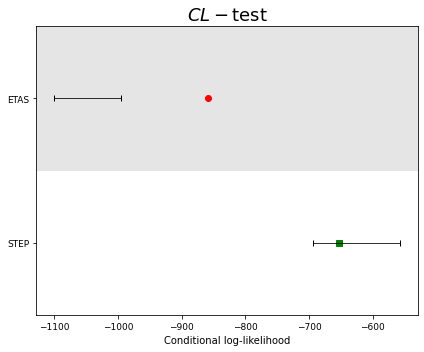

In [21]:
# set options for plotting
args = {'figsize': (6,5), # size of the figure
        'title': r'$CL-\mathrm{test}$', # figure title
        'title_fontsize': 18, # font size
        'xlabel': 'Conditional log-likelihood', # label on the x-axis
        'xticks_fontsize': 9, # font size of the ticks on the x-axis
        'ylabel_fontsize': 9, # font size of the label on the y-axis
        'linewidth': 0.8, # width of the line
        'capsize': 3,  # segment caps
        'tight_layout': True} # matplotlib tight layout

cond_L_results = [cond_likelihood_test_ETAS, cond_likelihood_test_STEP]
ax = plots.plot_poisson_consistency_test(cond_L_results, one_sided_lower=False, plot_args=args)
# Needed to show plots if running as script
plt.show()

The figure above only shows the $95\%$ confidence interval of the values of the statistic on the synthetic catalogues, but we may be interested in looking at the actual distribution of the statistic rather than just the confidence interval. The `pyCSEP` library provides access to the value of the statistics calcualted on the synthetic and observed catalogues. These values are stored in the `cond_likelihood_test_ETAS` and `cond_likelihood_test_STEP` object created above. The values of the statistic on the synthetic catalogues are simply a list of numbers, and once we have accessed it we can plot it using any python library. Here, we show how to retrieve this information for the ETAS model and we use the `matplotlib` library to plot the results.

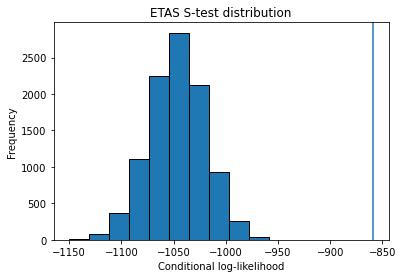

In [22]:
CL_synth_stat_ETAS = cond_likelihood_test_ETAS.test_distribution # values of the statistic on the synthetic catalogues
CL_obs_stat_ETAS = cond_likelihood_test_ETAS.observed_statistic # value of the statistic on the observed catalogue
# plot it
plt.hist(CL_synth_stat_ETAS, edgecolor = 'black')
plt.axvline(CL_obs_stat_ETAS)
plt.title('ETAS S-test distribution')
plt.xlabel('Conditional log-likelihood')
plt.ylabel('Frequency')
plt.show()

We can calculate the N-, S-, and M-test adapting the code above. The only difference is the test function from `csep.core.poisson_evaluations` that we use. The code below compute the tests and plot the results.

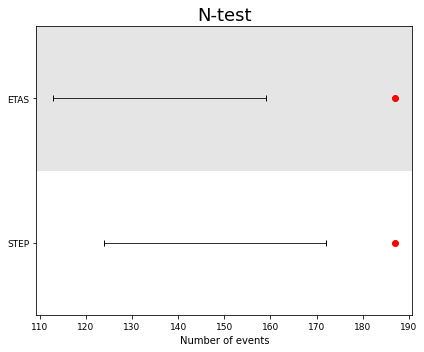

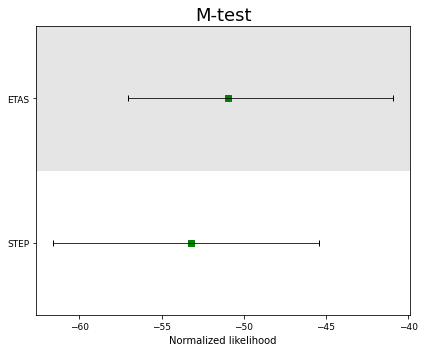

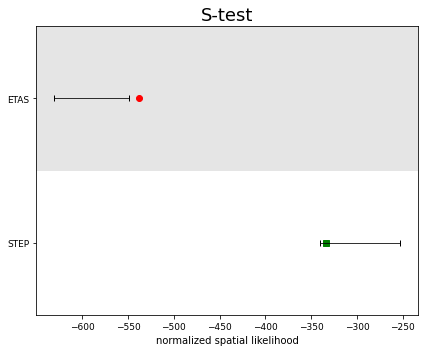

In [23]:
# Compute N-test
number_test_ETAS = poisson.number_test(cumulative_ETAS, catalog) # N-test needs less arguments as it does not create synthetic catalogues
number_test_STEP = poisson.number_test(cumulative_STEP, catalog)
# Set plot arguments
args['title'] = 'N-test'
args['xlabel'] = 'Number of events'
# Plot N-test
N_results = [number_test_ETAS, number_test_STEP]
ax = plots.plot_poisson_consistency_test(N_results, one_sided_lower=False, plot_args=args)
plt.show()

# Compute M-test
mag_test_ETAS = poisson.magnitude_test(
    cumulative_ETAS,
    catalog,
    seed=1,
    num_simulations=10000
)
mag_test_STEP = poisson.magnitude_test(
    cumulative_STEP,
    catalog,
    seed=1,
    num_simulations=10000
)
# Set plot arguments
args['title'] = 'M-test'
args['xlabel'] = 'Normalized likelihood'
# Plot M-test
M_results = [mag_test_ETAS, mag_test_STEP]
ax = plots.plot_poisson_consistency_test(M_results, one_sided_lower=False, plot_args=args)
# Needed to show plots if running as script
plt.show()


# Compute S-test
spatial_test_ETAS = poisson.spatial_test(
    cumulative_ETAS,
    catalog,
    seed=1,
    num_simulations=10000
)
spatial_test_STEP = poisson.spatial_test(
    cumulative_STEP,
    catalog,
    seed=1,
    num_simulations=10000
)
# Plot S-test
args['title'] = 'S-test'
args['xlabel'] = 'normalized spatial likelihood'
S_results = [spatial_test_ETAS, spatial_test_STEP]
ax = plots.plot_poisson_consistency_test(S_results, one_sided_lower=False, plot_args=args)
plt.show()




### Consistency tests for daily forecasts

We provide functions to calculate the `PyCSEP` consistency tests for each day. To perform this task, we provide the function `test_per_day` that works for all the test except the N-test for which we provide the funtion `Ntest_per_day`. The `test_per_day` function requires the test to be passed as input (`test_fun`), and we can use the `PyCSEP` functions used in the previous section. Then, the function calculates the test results for each day where _there are observations_, and ignores the days with no observations. The function produces a plot where, for each day with observations, is shown a dot representing the observed statistic and a segment representing the confidence interval of level $\alpha$ (`alpha_`) of the statistics calculated on synthetic catalogues from the forecasting model. When argument `plot_out = True` figures as the ones below are produced. Regardless of the `plot_out` argument, the function returns a `pandas.DataFrame` with each row representing a day with observations, and column representing the day under evaluation, the value of the statistic calculated on the observed catalogue, the lower and upper quantiles (of level $\alpha/2$ and $1 - \alpha/2$) of the stastistic calculated on the synthetic catalogues, the quantile score (basically the proportion of times the synthetic catalogues' stastistic is below the observed one), and if the test is passed or not (this is useful to be able to retrieve these days to better analyse them).  

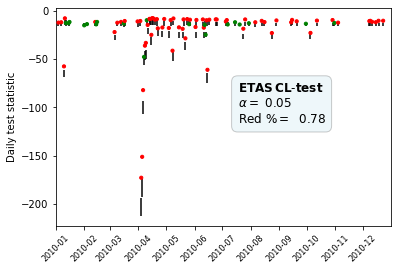

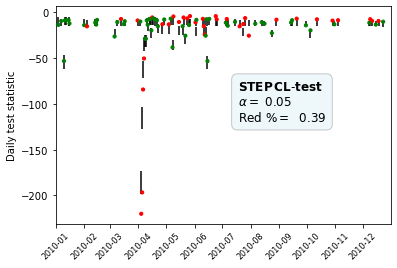

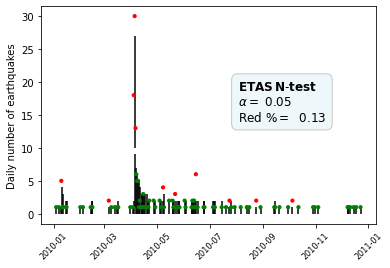

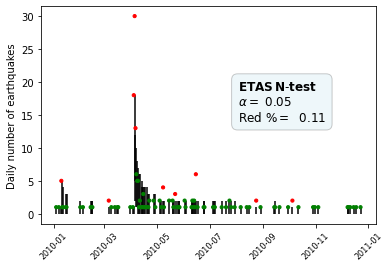

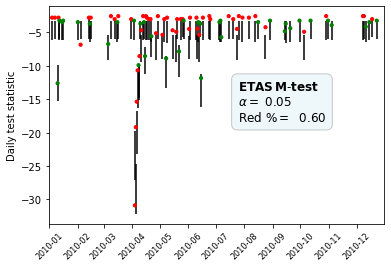

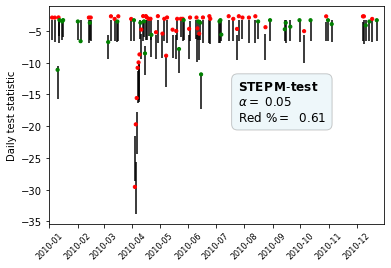

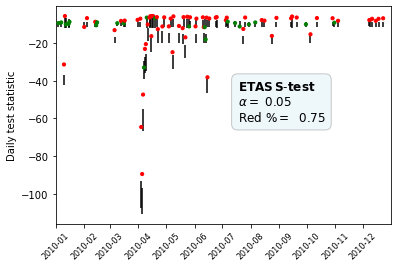

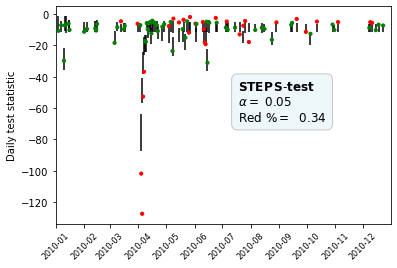

In [24]:

# conditional likelihood test
CL_ETAS_perday = f_hdf5.test_per_day(dict_fore= ETAS_2010, # forecast in dict format
                                     catalog= catalog, # observed catalogue
                                     test_fun=poisson.conditional_likelihood_test, # pyCSEP function calculating the test 
                                     alpha_= 0.05, # level for the confidence intervals   
                                     size_p = 10, # size of the point representing observed statistic
                                     plot_title= r'$\mathbf{ETAS\,CL}$-$\mathbf{test}$', # title of the box inside the plot
                                     plot_out= True, # flag indicating if the output plot is showed
                                     save_plot = True, # set if plot has to be saved locally
                                     file_title = 'CL_perday_ETAS.png',  # name of the file saved locally
                                     fig_dpi = 500, # resolution of the figure
                                     box_pos = (0.55, 0.5) ) # position of the box inside the plot
CL_STEP_perday = f_hdf5.test_per_day(dict_fore= STEP_2010,
                                     catalog= catalog,
                                     test_fun=poisson.conditional_likelihood_test, 
                                     alpha_= 0.05,   plot_out= True, 
                                     plot_title= r'$\mathbf{STEP\,CL}$-$\mathbf{test}$',
                                    save_plot = True,
                                     size_p = 10,
                                     file_title = 'CL_perday_STEP.png', 
                                     fig_dpi = 500,
                                     box_pos = (0.55, 0.5))

# N-test
N_ETAS_perday = f_hdf5.Ntest_per_day(dict_fore= ETAS_2010,
                                     catalog= catalog,
                                     alpha_= 0.05,   
                                     plot_out= True, 
                                     plot_title= r'$\mathbf{ETAS\,N}$-$\mathbf{test}$',
                                     save_plot = True,
                                     size_p = 10,
                                     file_title = 'N_perday_ETAS.png', 
                                     fig_dpi = 500,
                                     box_pos = (0.55, 0.5))
N_STEP_perday = f_hdf5.Ntest_per_day(dict_fore= STEP_2010,
                                     catalog= catalog,
                                     alpha_= 0.05,   plot_out= True, 
                                     plot_title= r'$\mathbf{ETAS\,N}$-$\mathbf{test}$',
                                     save_plot = True,
                                     size_p = 10,
                                     file_title = 'N_perday_STEP.png', 
                                     fig_dpi = 500,
                                     box_pos = (0.55, 0.5))

# M-test
M_ETAS_perday = f_hdf5.test_per_day(dict_fore= ETAS_2010,
                                    catalog= catalog,
                                    test_fun=poisson.magnitude_test, 
                                    alpha_= 0.05,   plot_out= True, 
                                    plot_title= r'$\mathbf{ETAS\,M}$-$\mathbf{test}$', 
                                    save_plot = True,
                                    size_p = 10,
                                    file_title = 'M_perday_ETAS.png', 
                                    fig_dpi = 500,
                                    box_pos = (0.55, 0.5))
M_STEP_perday = f_hdf5.test_per_day(dict_fore= STEP_2010,
                                    catalog= catalog,
                                    test_fun=poisson.magnitude_test, 
                                    alpha_= 0.05,   plot_out= True, 
                                    plot_title= r'$\mathbf{STEP\,M}$-$\mathbf{test}$',
                                    save_plot = True,
                                    size_p = 10,
                                    file_title = 'M_perday_STEP.png', 
                                    fig_dpi = 500,
                                   box_pos = (0.55, 0.5))

# S-test
S_ETAS_perday = f_hdf5.test_per_day(dict_fore= ETAS_2010,
                                    catalog= catalog,
                                    test_fun=poisson.spatial_test, 
                                    alpha_= 0.05,   plot_out= True, 
                                    plot_title= r'$\mathbf{ETAS\,S}$-$\mathbf{test}$',
                                    save_plot = True,
                                    size_p = 10,
                                    file_title = 'S_perday_ETAS.png', 
                                    fig_dpi = 500, 
                                    box_pos = (0.55, 0.5))

S_STEP_perday = f_hdf5.test_per_day(dict_fore= STEP_2010,
                                    catalog= catalog,
                                    test_fun=poisson.spatial_test, 
                                    alpha_= 0.05,   plot_out= True, 
                                    plot_title= r'$\mathbf{STEP\,S}$-$\mathbf{test}$',
                                    save_plot = True,
                                    size_p = 10,
                                    file_title = 'S_perday_STEP.png', 
                                    fig_dpi = 500, 
                                    box_pos = (0.55, 0.5))



## CSEP comparison tests
In this Section, we show how to compute CSEP comparisons tests on cumulative and daily forecasts as we have done for the CSEP comparisons tests. The logic underlying this apporach is different from the one used for consistency tests, and therefore, also the interpretation of the results is different. In CSEP consistency tests, we look at how much difference there is between the values of the test statistic calculated on synthetic catalogues simulated accordingly to the forecasting model and on the observed catalogue. On one hand, this provides information on how the synthetic catalogues differ from the observed one, but on the other hand, this provides little information on which model has the highest predictive capabilities. The latter is typically assessed using a scoring function (or score), which is simply a function of a forecast and the observations. The interpretation of the score depends on its orientation; for positively oriented scores a higher value suggests better predictive skills, while a lower value indicates the same when negatively oriented. Of course, there exist multiple scoring functions that can be employed for the same problem. For example, scores with different orientations or with different theoretical properties (e.g. proper vs improper, bounded vs unbounded) lead to multiple ways to compare two forecats. Regardless of the scoring function, and its orientation, a common way to study the difference in predictive perfomance is to study the difference in scores between two models on the same observations.  

Here, we compare the perfomance of the ETAS model against STEP using earthquakes occurred in 2010. We show two methods provided by pyCSEP to compare forecasts. For the cumulative forecasts, we use the information gain per earthquake (IGPE), while for the daily forecasts we use the Kagan information score. We made this choice for illustrative purposes and not because one of the score is better in a certain situation, both scores indeed provide similar information. We start with the cumulative case, and proceed with the daily case later.

### Comaparison tests for cumulative forecasts

For this case, we use the IGPE to compare the forecasts. The IGPE is basically the difference between the point process log-likelihoods provided by the models. The point process log-likelihood is given by the sum of the logarithm of the intensity at the observed point minus the expected number of points in the area by the model. So the IGPE between two model is given by the sum of the differences in log-intensities calculated at the observations minus the difference in the expected number of points. In this context, the point-process log-likelihood can be considered a positively oriented score, meaning the higher the likelihood the model assigns to the observations, the better the model. Therefore, positive values of IGPE suggests a preference for the first model, while negative for the second one. 

One of the problems in comparing cumulative forecasts or any forecast for a single time period (opposed to multiple time periods as in the daily case) is estimating the significance of the observed score differnce. In principle, we would like to answer the question, is the difference positive because the first model is sistematically better than the other, or by chance? This situation is problematic because we only have one value of the difference (the difference in score in the forecasting period) and so estimating its variability requires us to make some assumptions. In pyCSEP, the approximation proposed by [Rhoades (2011)](https://link.springer.com/article/10.2478/s11600-011-0013-5) in which the score differences are approximated by a Gaussian distribution. In this way, a t-test can be performed and the significance of the results estimated. For more details on the approximation, the reader can consult the reference provided above, or the [pyCSEP theory webpage](https://docs.cseptesting.org/getting_started/theory.html).

The pyCSEP library provides tools to compute this approximated t-test on the IGPE value. This is done using the function `paired_t_test()` function of the `poisson_evaluations` module of pyCSEP (the same where the consistency tests are). The function just requires two forecasts in  `csep.core.forecasts.GriddedForecast` format, and an observed catalogue in `csep.core.catalogs.CSEPCatalog` format. Once the test is computed, we can plot the result using the `paired_t_test()` function. The plot shows the value of the IGPE (the red point) along with the $95\%$ confidence interval obtained using the Gaussian approximation (red vertical segment). If the interval contains zero, then the IGPE is not significantly different from zero, and therefore we can not express a clear preference; if the interval does not contain zero, then the IGPE significantly differnt from zero. In this case, we compared ETAS against STEP, the IGPE is negative, the interval does not contains zero, and therefore we can express a preference for the STEP model. 

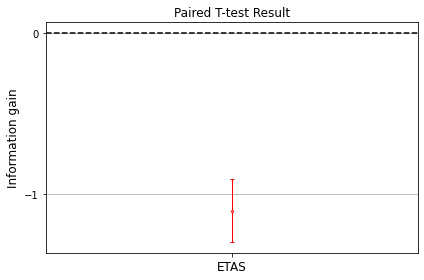

In [25]:
t_test = poisson.paired_t_test(cumulative_ETAS, # model 1 
                               cumulative_STEP, # base model (this is represented by 0 on the plot) 
                               catalog) # observations

# set arguments for the plot
comp_args = {'title': 'Paired T-test Result',
             'ylabel': 'Information gain',
             'xlabel': '',
             'xticklabels_rotation': 0,
             'figsize': (6,4)}
# plot
ax = plots.plot_comparison_test([t_test], plot_args=comp_args)
plt.show()

### Comparison tests for daily forecasts

For the comparison of daily forecasts produced by alternative models, we show how to use the Kagan information score differences. The Kagan information score for a forecast given a set of observations is given by the average intensity provided by the model at the observations locations. The intensity at an observed location is simply the expected rate in the corresponding space-magnitude bin, and the score is given by the average over the observed earthquakes. This means that also the Kagan score is positively oriented, and models with higher score assigns higher probability to the observations, and so should be preferred. Therefore we can study the score difference, where positive differences are a sign that the first model should be preferred, and the opposite is true for negative differences. When analysing multiple periods of time, a summary measure of the overall perfomance of a model is given by the cumulative Kagan information score, so we can compare the models over multiple periods by considering the cumulative score differences.

Analysing daily forecasts imply that we have a score difference for each day. This has two advantages. The first one is that we can highlight periods where one of the model fits the observations better than the alternative by simply looking at the sign of the differences. Secondly, we can estimate if the score difference is significantly different from zero for each day using a Gaussian approximation, as done in the cumulative case. But, we can also study the if the average score difference is different from zero by performing a t-test on the daily differences. With the first method we asses if the differnce in each day is significantly different from zero, while the second method assess if the average difference over multiple forecasting periods is different from zero. 

We provide code to automatically calculate the Kagan score difference for each day given two dictionaries of forecasts created from the corresponding `hdf5` files. This is done with the `score_diff_per_day()` function from the code we provide to analyse `hdf5` forecasts. The function takes in input two dictonaries of forecasts, an observed catalogue in `csep.core.catalogs.CSEPCatalog` format, and a scoring function. The scoring function must take the forecast in `csep.core.forecasts.GriddedForecast` format as first input and the catalogue as second one, and return the score of the forecast. The function returns a `pandas.DataFrame` in output with 2 columns: the date, and corresponding the score difference.

For this example, we use the `get_Kagan_I1_score()` function provided by `pyCSEP`. 

In [26]:
# calculate the score difference per each day (score_dict_fore1 - score_dict_fore2)
Kagan_information_diff_per_day = f_hdf5.score_diff_per_day(dict_fore1 = ETAS_2010, # forecast in dict format 
                                                           dict_fore2 = STEP_2010, # forecast in dict format
                                                           catalog = catalog,  # observed catalogue
                                                           score_fun = csep.utils.stats.get_Kagan_I1_score ) # scoring function

# redefine index - without the following two commands the dates are not sorted
df = Kagan_information_diff_per_day.set_index(Kagan_information_diff_per_day['day'])
df.sort_index(inplace = True)
print(df.head()) # have a look

            score_diff        day
day                              
2010-01-04    2.004085 2010-01-04
2010-01-07   -2.617578 2010-01-07
2010-01-10   -0.440033 2010-01-10
2010-01-11    2.375062 2010-01-11
2010-01-12   -4.507242 2010-01-12


Once we have computed the score difference for each day, we have two ways of illustrating the differences. We can plot the evolution of the absolute differences in time, or the cumulative ones. The first method gives us an idea of the which model fits the data better in each day, and also of the magnitude of the difference differences (larger differences indicate a stronger evidence for model 1, viceversa if negative). The second method provides information on which model provides the best overall fit to the observations over multiple periods. Also, providing the complete list of score differences per day allows to calculate some interesting statistics as the percentage of times the difference is positive and similar.   

The code below calculates the cumulative score difference from the absolute ones, and shows a way to plot the absolute score differences and one to plot the cumulative ones. In both cases, green points indicate days of positive differences, while red points days where is negative. For the absolute differences we simply show the time series of the score differences. Vertical grey lines represents the occurrence time of the observed earthquakes. From this plot, we see that the majority of points are red (so negative differences), however ETAS has the highest peaks. This information is precious because if ETAS ends up being preferred overall, it would be due to few high positive peaks in score difference rather than a consistent positive trend. Regarding the cumulative differences, we show the time series of the cumulative differences along with the histogram of the daily number of events. From this figure is clear that the STEP model overperforms the ETAS model, especially during the aftershock sequence. This is indicated by the fact that the cumulative score difference is monotonically decreasing in the days after the weeks after the peak in number of events indicating the occurrence of the $7.2 M_w$ El-Major Cucapah earthquake. 

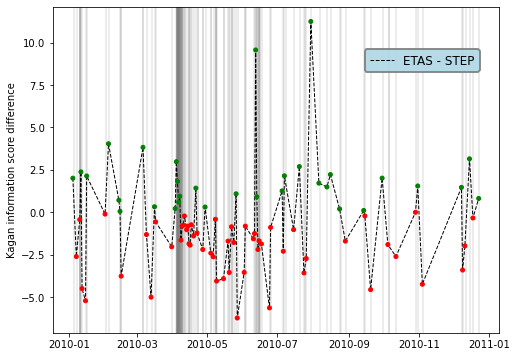

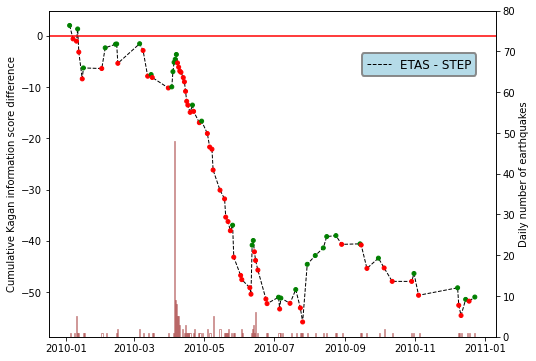

In [27]:
# calculate cumulative score differences
df['cumulative_score_diff'] = np.cumsum(df['score_diff'])

# color of each point - green positive score differences, red otherwise
color_code = ['green' if condition else 'red' for condition in df['score_diff'] > 0]
green_perc =  df['score_diff'] > 0 # example - calculating percentage of positive differences

# retireve time of observed earthquakes
timestamp_ms = catalog.to_dataframe()['origin_time'] #get observed time stamps
timestamp_s = timestamp_ms / 1000.0 # scale it
date_time = [datetime.fromtimestamp(t) for t in timestamp_s] # transform it in datetime object
obs_mags = catalog.to_dataframe()['magnitude'] # get observed magnitudes
#date_M5plus = [date_time[idx] for idx in np.arange(0, len(date_time)) if obs_mags[idx] >= 3.95] #  

# Absolute differences plot
# initialise figure
fig, ax1 = plt.subplots(figsize=(8, 6))
# plot dashed line
ax1.plot(df['day'], df['score_diff'], label = 'ETAS - STEP', c = 'black', linewidth = 1, linestyle = '--', zorder = 1)
# plot absolute score differences (the points)
ax1.scatter(df['day'], df['score_diff'], s = 16, c = color_code, zorder = 2)
# add vertical lines at occurence times of the observations
for obs_date in date_time:
    ax1.axvline(obs_date, c = 'grey', alpha = 0.2, zorder = 0)
# set y-axis label
ax1.set_ylabel('Kagan information score difference', fontsize = 10)
# include legend
plt.legend(loc = (0.7, 0.8), frameon = True, fancybox = True, framealpha = 0.9, facecolor = 'lightblue', edgecolor = 'grey',
                   fontsize=12).get_frame().set_linewidth(2)
# save the figure
plt.savefig('Kagan_abs_diff.png', dpi = 500,  bbox_inches = 'tight')
plt.show()

# Cumulative differences plot
fig, ax1 = plt.subplots(figsize=(8, 6))
# plot dashed line
ax1.plot(df['day'], df['cumulative_score_diff'], label = 'ETAS - STEP', c = 'black', linewidth = 1, linestyle = '--', zorder = 1)
# plot cumulative score differences (the points)
ax1.scatter(df['day'], df['cumulative_score_diff'], s = 16, c = color_code, zorder = 2)
# plot horizontal line at zero
ax1.axhline(0, c = 'red')
# set y-axis label (left side)
ax1.set_ylabel('Cumulative Kagan information score difference', fontsize = 10)
# include legend
ax1.legend(loc = (0.7, 0.8), frameon = True, fancybox = True, framealpha = 0.9, facecolor = 'lightblue', edgecolor = 'grey',
                   fontsize=12).get_frame().set_linewidth(2)
# Create a second axis (for the histogram) on the right
ax2 = ax1.twinx()
# plot histogram
ax2.hist(date_time, bins = 52*7, color='white', edgecolor = 'darkred', alpha=0.4, label="M+3.95 Earthquakes", zorder = 0)
# set y-axis label (right side)
ax2.set_ylabel('Daily number of earthquakes', fontsize = 10)
# set y ticks 
ax2.tick_params(axis='y', labelcolor='black')
# set limits on the y-axis (right side)
ax2.set_ylim(0, 80)
# set x ticks
plt.xticks(fontsize = 8, rotation = 45)
# save the figure
plt.savefig('Kagan_cumulative_diff.png', dpi = 500,  bbox_inches = 'tight')
plt.show()

## Cumulative forecasts for custom time periods

In the beginning of the tutorial, we created cumulative forecasts from the dictonary of forecasts representing the `.hdf5` files. The code we used creates a cumulative forecast considering all the days for which we have forecasts. However, the `get_cumulative_forecast` function we provide also allows to create cumulative forecasts for custom time periods as one may be interested in specific days, or weeks. In this way, one can repeat the above analysis for custom time periods of time.

Here, we consider the El-Mayor Cucapah earthquake occurred on the 04 April 2010 and create a cumulative forecast for the week after the event (from 04 April 2010 to 11 April 2010). To do this, we semply need to set `all_dates = False`, and set a `start_date` and `end_date`. The functions returns a cumulative forecast in  `csep.core.forecasts.GriddedForecast` format for the specified period. Below, we show how to create the cumulative forecast, filter the 2010 observed catalogue, and plot the spatial distribution of the forecast along with the observations.

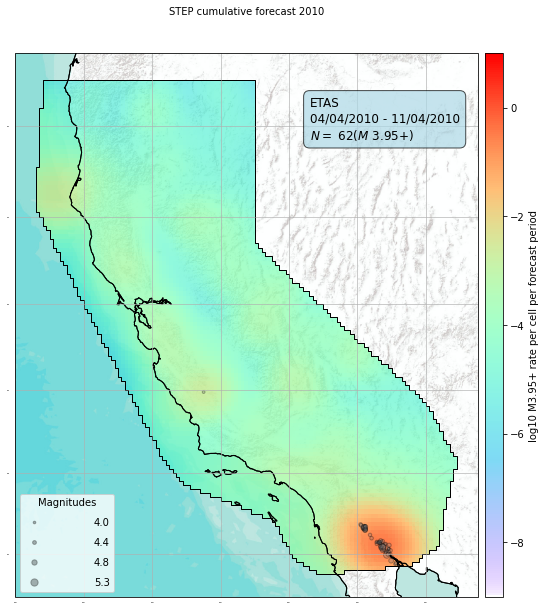

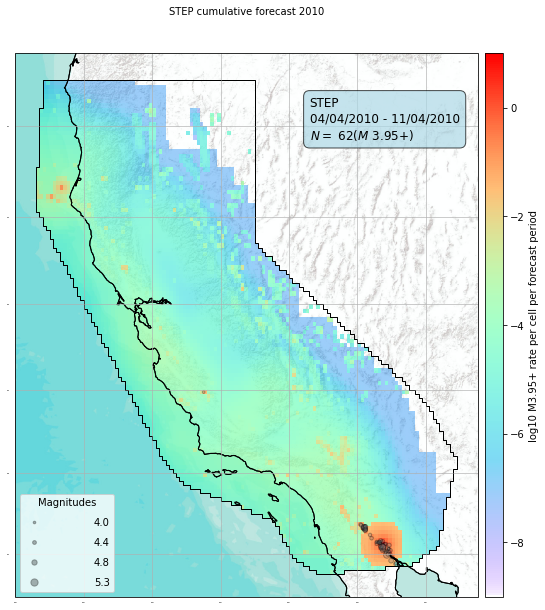

In [28]:
# cumulative forecast for custom time interval 
# ETAS model
week_ETAS = f_hdf5.get_cumulative_forecast(dict_fore = ETAS_2010, # forecast dictonary
                                            forecast_name = 'ETAS 04-11/04/2010', # name of the forecast (used for plotting)
                                            start_date = '04/04/2010 00:00:00', # %d/%m/%yyy hours:minutes:seconds
                                            end_date = '11/04/2010 23:59:59',
                                            all_dates = False) 
# STEP model
week_STEP = f_hdf5.get_cumulative_forecast(dict_fore = STEP_2010, 
                                            forecast_name = 'STEP 04-11/04/2010', 
                                            start_date = '04/04/2010 00:00:00', 
                                            end_date = '11/04/2010 23:59:59',
                                            all_dates = False) 

# set start and end date of the catalogue
start_epoch = csep.utils.time_utils.strptime_to_utc_epoch('2010-04-05 00:00:00') # format yyyy-mm-dd 
end_epoch = csep.utils.time_utils.strptime_to_utc_epoch('2010-04-11 23:59:00')

# set filters for catalog 
filters = [f'origin_time >= {start_epoch}', f'origin_time < {end_epoch}']
# filter the 2010 catalogue
catalog_week = catalog.filter(filters, 
                             in_place = False) # this option creates another catalogue otherwise it filters the original!

# set plotting arguments
args_forecast = {'grid_labels': True,
                 'basemap': 'ESRI_imagery', # set background image if non a black and white (ESRI_terrain) version of the costline is used
                 'cmap': 'rainbow', # color palette for the logarithm of number of events 
                 'alpha_exp': 0.5, # level of trasparency
                 'projection': cartopy.crs.Mercator(), # projection
                 'clim':[-9, 1]} # limits of the color scale 

# change parameter for catalog plotting
args_catalog['markercolor'] = 'grey' # color for the observations
# plot spatial distribution
ax_1 = week_ETAS.plot(plot_args=args_forecast)
# superimpose observations
ax_2 = catalog_week.plot(ax=ax_1, plot_args=args_catalog)
# set box with summary information
ax_2.annotate('ETAS'+ '\n' + '04/04/2010 - 11/04/2010' + '\n' + fr'$N = $ {int(catalog_week.event_count) :.0f}' + r'($M$ 3.95+)', 
             xy=(0.5, 0.5), xycoords='figure fraction',
             xytext= (0.43, 0.65), textcoords='figure fraction',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.7),
             fontsize=12,
             horizontalalignment='left', verticalalignment='bottom')
plt.savefig('weekly_ETAS.png', dpi = 500, bbox_inches = 'tight')

# plot spatial distribution
ax_1 = week_STEP.plot(plot_args=args_forecast)
# superimpose observations
ax_2 = catalog_week.plot(ax=ax_1, plot_args=args_catalog)
# set box with summary information
ax_2.annotate('STEP'+ '\n' + '04/04/2010 - 11/04/2010' + '\n' + fr'$N = $ {int(catalog_week.event_count) :.0f}' + r'($M$ 3.95+)', 
             xy=(0.5, 0.5), xycoords='figure fraction',
             xytext= (0.43, 0.65), textcoords='figure fraction',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.7),
             fontsize=12,
             horizontalalignment='left', verticalalignment='bottom')
plt.savefig('weekly_STEP.png', dpi = 500, bbox_inches = 'tight')

## Benchmarking

The database of next-day gridded-forecasts for California we described here can be used as benchmark for future problems. In fact, new forecasting models can be evaluated using the code and statistical methods provided by CSEP and results compared against the ones obtained by models in the database. This brings multiple advantages: we can quantify the improvements in forecasting performance of new models, if we repeat this operation through time we can track such improvements; we can identify periods where the model does not fit well the data, and check if this is the case also for models in the database; we can cross-compare multiple new models having a common point of comparison, if this becomes standard practice we can produce meta analysis (as it is done in other science fields) providing a more complete picture of the state of our capabilities to forecast future seismicity. But the benchmarking does not only regards new models, but also new testing metrics. Indeed, having such unprecendented database of forecasts produce by models with known difference provides data to assess the capabilities of new testing metrics in distinguishing between models. Essentially, it offers a standardinsed problem with which comparing the performance of new testing metrics and techniques. This Section is divided in two, the first one shows how to create a `hdf5` file from a set of nested folder containing daily forecasts. The second shows how to modify the code we provide to use new testing metrics. In this way, this code can be reused by the user to convert their forecasts in `hdf5` format and compare the perfomance of their model against models in the database, and to compare the evaluations obtained with new and established tests. 

### Converting forecasts to `hdf5` format

We provide the `create_hdf5_from_folder_structure()` function to convert a set of forecasts organised in a system of nested folders to a `.hdf5` file. This is not only useful to reuse the code we illustrated here, but also because `.hdf5` are lighter and more manageable than a system of nested folders. To use our function, the system of nested folders, and the name of the forecast files, must follow the same convention. The forecasts must be organised in a top level folder containing one folder per year named accordingly (e.g. `'2010'` for year 2010). Each year folder contains one folder for each month for which the model has produced forecasts named with the number of the corresponding month (e.g. `'1'` for January). Each month folder contains one `.dat` file for each forecasted day. The name of the forecast `.dat` must contain the reference date in the `%d_%m_%Y` format (e.g. `'1_1_2010'` for the 1st January 2010). The `.dat` file must follow the same structure as the ones in the database: one row for each space-magnitude bin (391782 for the models in the database), and ten columns (minimum and maximum longitude, minimum and maximum latitude, minimum and maximum depth, minimum and maximum magnitude, expected number of events in the bin, and an identifier which should always be 1). More information on this format can be found on the [pyCSEP website](https://docs.cseptesting.org/concepts/forecasts.html).  

We provide an example forecast to be used as template. The forecast provides daily forecasts for January 2010, and for simplicity we set the earthquake rate in each space-magnitude bin to be equal 1. So, the folder representing this model contains a year folder named `'2010'` with inside a month folder named `'1'`, with inside 31 files corresponding to the daily forecasts. To visually check if a model folder has the correct structure we provide the `print_tree()` function that takes as input the path of the folder containing the forecasts and prints the nested structure as shown below. 

In [29]:
f_hdf5.print_tree('E:/CSEP1_one_day_Copy/Example_model/')

|-- /
    |-- Example_forecast.hdf5
|-- 2010/
    |-- 1/
        |-- forecast_1_10_2010.dat
        |-- forecast_1_11_2010.dat
        |-- forecast_1_12_2010.dat
        |-- forecast_1_13_2010.dat
        |-- forecast_1_14_2010.dat
        |-- forecast_1_15_2010.dat
        |-- forecast_1_16_2010.dat
        |-- forecast_1_17_2010.dat
        |-- forecast_1_18_2010.dat
        |-- forecast_1_19_2010.dat
        |-- forecast_1_1_2010.dat
        |-- forecast_1_20_2010.dat
        |-- forecast_1_21_2010.dat
        |-- forecast_1_22_2010.dat
        |-- forecast_1_23_2010.dat
        |-- forecast_1_24_2010.dat
        |-- forecast_1_25_2010.dat
        |-- forecast_1_26_2010.dat
        |-- forecast_1_27_2010.dat
        |-- forecast_1_28_2010.dat
        |-- forecast_1_29_2010.dat
        |-- forecast_1_2_2010.dat
        |-- forecast_1_30_2010.dat
        |-- forecast_1_31_2010.dat
        |-- forecast_1_3_2010.dat
        |-- forecast_1_4_2010.dat
        |-- forecast_1_5_2010.dat
   

Once the model folder has the correct structure, we can use the function `create_hdf5_from_folder_structure()` to create the `.hdf5` file containing the forecasts. The function requires the path of the model folder, and the path of the `.hdf5` returned as output. In the example below, we create a `.hdf5` file called `Example_forecast.hdf5` representing the example model forecasts. 

In [31]:
path = 'Example_model/'
f_hdf5.create_hdf5_from_folder_structure(root_dir = path, 
                                        data_type='num',
                                        hdf5_filename= 'Example_forecast.hdf5' )


HDF5 file 'Example_forecast.hdf5' created successfully.


Then, we can load the forecast and analyse it. Here, we load the `.hdf5` file, we filter the catalogue to January 2010, and we plot the daily log number of earthquakes provided by the forecast. In this example, given that the rate in each space-magnitude bin is 1 for all forecasts we expect this to be constant. 

Loading year: 2010


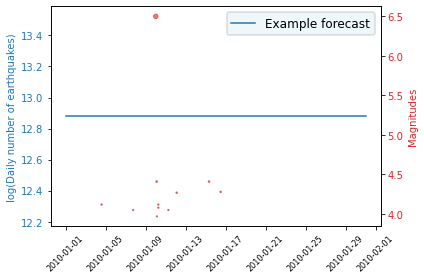

In [32]:
example_forecast = f_hdf5.load_hdf5_to_dict(hdf5_filename='Example_forecast.hdf5', all_dates=True)

# set start and end date of the catalogue
start_epoch = csep.utils.time_utils.strptime_to_utc_epoch('2010-01-01 00:00:00') # format yyyy-mm-dd 
end_epoch = csep.utils.time_utils.strptime_to_utc_epoch('2010-01-31 23:59:00')

# set filters for catalog 
filters = [f'origin_time >= {start_epoch}', f'origin_time < {end_epoch}']
# filter the 2010 catalogue
catalog_Jan = catalog.filter(filters, 
                             in_place = False) # this option creates another catalogue otherwise it filters the original!

# plot daily log number of earthquake
f_hdf5.get_N_plot_multi(dict_fore_array=[example_forecast], # list of dictonaries of forecasts
                        forecast_label = ['Example forecast'],  # list of forecasts names
                        catalog=catalog_Jan,  # observed catalogue
                        alpha_level =  0.05,  # level of the confidence intervals
                        type = 'rates', # type of plot (if = 'cumulative' produces the cumulative plot) 
                        size_p = 20, # size of the points in the plot
                        return_df = False, # returning a Pandas.data.frame used for plotting 
                        save_plot = False, # saving the plot  
                        show_obs_counts = False, # show observed counts
                        show_uncertainty = False)

### Designing new testing metrics

The next-day gridded forecasts database can also be used as benchmark when designing new metrics. Indeed, having a fixed set of models with known differences provides a benchmark problem to assess the capabilities of new testing metrics in distinguishing between forecasts or in spotting incosistency between forecasts and observations. To this end, we provide functions `test_per_day()` and `score_diff_per_day()` that take in input, respectively, a testing function (`test_fun`) and a scoring function (`scoring_fun`). Both functions needs to take as first argument a forecast in `csep.core.forecasts.GriddedForecast` format, and an observed catalogue in `csep.core.catalogs.CSEPCatalog` format. The testing function to be used for consistency tests must return an object  with at least the following three attributes: `observed_statistic` (list of value of the testing function calculated on the observed catalogue), `test_distribution` (values of the testing function calculated on the synthetic catalogues), and `quantile`(percentage of synthetic catalogues with value of the test statistic smaller or equal than the observed one). The scoring function must return a list with first element the value of the score calculated on the input forecast and observations. 

## Additional resources
* Github page with old workshops' material : https://github.com/cseptesting
* pyCSEP documentation website : https://docs.cseptesting.org/
* pyCSEP GitHub page : https://github.com/SCECcode/pycsep
* CSEP website : https://cseptesting.org/
* pyCSEP is an open-source and community developed library, and we are always looking for new collaborators. We have zoom calls every two weeks to coordinate the pyCSEP developements and discuss relevant topics, so if you are interested in collaborating, or if you are curious, just send an email to francesco.serafini@bristol.ac.uk